In [1]:
!pip install ISLP

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.0/522.0 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 9.2 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=219303f47085635f7753413b6ecdd4029aa246030dd4abb2d784e6993e2f5ade
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma
  Attempting 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)
from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
     QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from functools import partial
from sklearn.model_selection import cross_validate, KFold, ShuffleSplit
from sklearn.base import clone
from ISLP.models import sklearn_sm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import resample
import random
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [3]:
df = load_data('Hitters')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AtBat      322 non-null    int64   
 1   Hits       322 non-null    int64   
 2   HmRun      322 non-null    int64   
 3   Runs       322 non-null    int64   
 4   RBI        322 non-null    int64   
 5   Walks      322 non-null    int64   
 6   Years      322 non-null    int64   
 7   CAtBat     322 non-null    int64   
 8   CHits      322 non-null    int64   
 9   CHmRun     322 non-null    int64   
 10  CRuns      322 non-null    int64   
 11  CRBI       322 non-null    int64   
 12  CWalks     322 non-null    int64   
 13  League     322 non-null    category
 14  Division   322 non-null    category
 15  PutOuts    322 non-null    int64   
 16  Assists    322 non-null    int64   
 17  Errors     322 non-null    int64   
 18  Salary     263 non-null    float64 
 19  NewLeague  322 non-null    ca

In [4]:
df.nunique()

,0
AtBat,247
Hits,144
HmRun,36
Runs,96
RBI,103
Walks,89
Years,22
CAtBat,314
CHits,288
CHmRun,146


In [5]:
df.dropna(inplace = True)

In [6]:
category = list(df.loc[:, df.nunique() <= 5])
dummies = pd.get_dummies(df[category], drop_first = True).astype(int)


In [7]:
df = pd.concat([df, dummies], axis = 1)
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,...,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,...,N,W,632,43,10,475.0,N,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,...,A,W,880,82,14,480.0,A,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,...,N,E,200,11,3,500.0,N,1,0,1
4,321,87,10,39,42,30,2,396,101,12,...,N,E,805,40,4,91.5,N,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,...,A,W,282,421,25,750.0,A,0,1,0


In [8]:
X = df.drop(['Salary', 'Division', 'League', 'NewLeague'], axis = 1)
y = df['Salary']

X.info()



<class 'pandas.core.frame.DataFrame'>
Index: 263 entries, 1 to 321
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   AtBat        263 non-null    int64
 1   Hits         263 non-null    int64
 2   HmRun        263 non-null    int64
 3   Runs         263 non-null    int64
 4   RBI          263 non-null    int64
 5   Walks        263 non-null    int64
 6   Years        263 non-null    int64
 7   CAtBat       263 non-null    int64
 8   CHits        263 non-null    int64
 9   CHmRun       263 non-null    int64
 10  CRuns        263 non-null    int64
 11  CRBI         263 non-null    int64
 12  CWalks       263 non-null    int64
 13  PutOuts      263 non-null    int64
 14  Assists      263 non-null    int64
 15  Errors       263 non-null    int64
 16  League_N     263 non-null    int64
 17  Division_W   263 non-null    int64
 18  NewLeague_N  263 non-null    int64
dtypes: int64(19)
memory usage: 41.1 KB


# Feature Selection using forward that minimizes the MSE

In [9]:
def aic(X_train, y_train, model):
    n = len(y_train)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    SSE = np.sum(np.square(y_train - y_train_pred))
    p = X_train.shape[1] + 1 #Considering the intercept coeficient
    return n * np.log(SSE/n) + 2 * p

def bic(X_train, y_train, model):
    n = len(y_train)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    SSE = np.sum(np.square(y_train - y_train_pred))
    p = X_train.shape[1] + 1 #Considering the intercept coeficient
    return n * np.log(SSE/n) + p * np.log(n)

def r2_adj(X_train, y_train, model):
    n = len(y_train)
    model.fit(X_train, y_train)
    p = X_train.shape[1]
    r2 = model.score(X_train, y_train)
    return 1 - (1 - r2) * (n - 1)/ (n - p - 1)

def score_function_wrapper(metric, model):
    metrics = ['aic', 'bic', 'r2_adj']
    if metric == 'aic':
        return lambda X_train, y_train: -aic(X_train, y_train, model)  #Menus to minimize
    elif metric == 'bic':
        return lambda X_train, y_train: -bic(X_train, y_train, model)  #same
    elif metric == 'r2_adj':
        return lambda X_train, y_train: r2_adj(X_train, y_train, model)# The higher the better
    else:
        raise ValueError(f'{metric} is not in the following: {metrics}')

In [10]:
from mlxtend.feature_selection import SequentialFeatureSelector

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 2025)

lr1 = LinearRegression()
sfs1 = SequentialFeatureSelector(estimator = lr1 , k_features='best', forward=True, scoring='neg_mean_squared_error', n_jobs = -1)
model1 =  sfs1.fit(X_train, y_train)

print("Características seleccionadas:", sfs1.k_feature_names_)
print("Mejor puntuación (MSE negativo):", sfs1.k_score_)

results1 = sfs1.get_metric_dict()

num_features1 = []
mse_scores1 = []

for num, metrics in results1.items():
    num_features1.append(len(metrics['feature_idx']))
    mse_scores1.append(np.abs(metrics['avg_score']))

minimum_mse1 = min(mse_scores1)






Características seleccionadas: ('AtBat', 'Hits', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'PutOuts', 'League_N', 'Division_W', 'NewLeague_N')
Mejor puntuación (MSE negativo): -99680.30333570259


#Same procedure but using cv = 10

In [11]:
lr2 = LinearRegression()
sfs2 = SequentialFeatureSelector(estimator = lr2 , k_features='best', forward=True, scoring='neg_mean_squared_error', cv=10, n_jobs = -1)
model2 =  sfs2.fit(X_train, y_train)



results2 = sfs2.get_metric_dict()

num_features2 = []
mse_scores2 = []

for num, metrics in results2.items():
    num_features2.append(len(metrics['feature_idx']))
    mse_scores2.append(np.abs(metrics['avg_score']))

minimum_mse2 = min(mse_scores2)





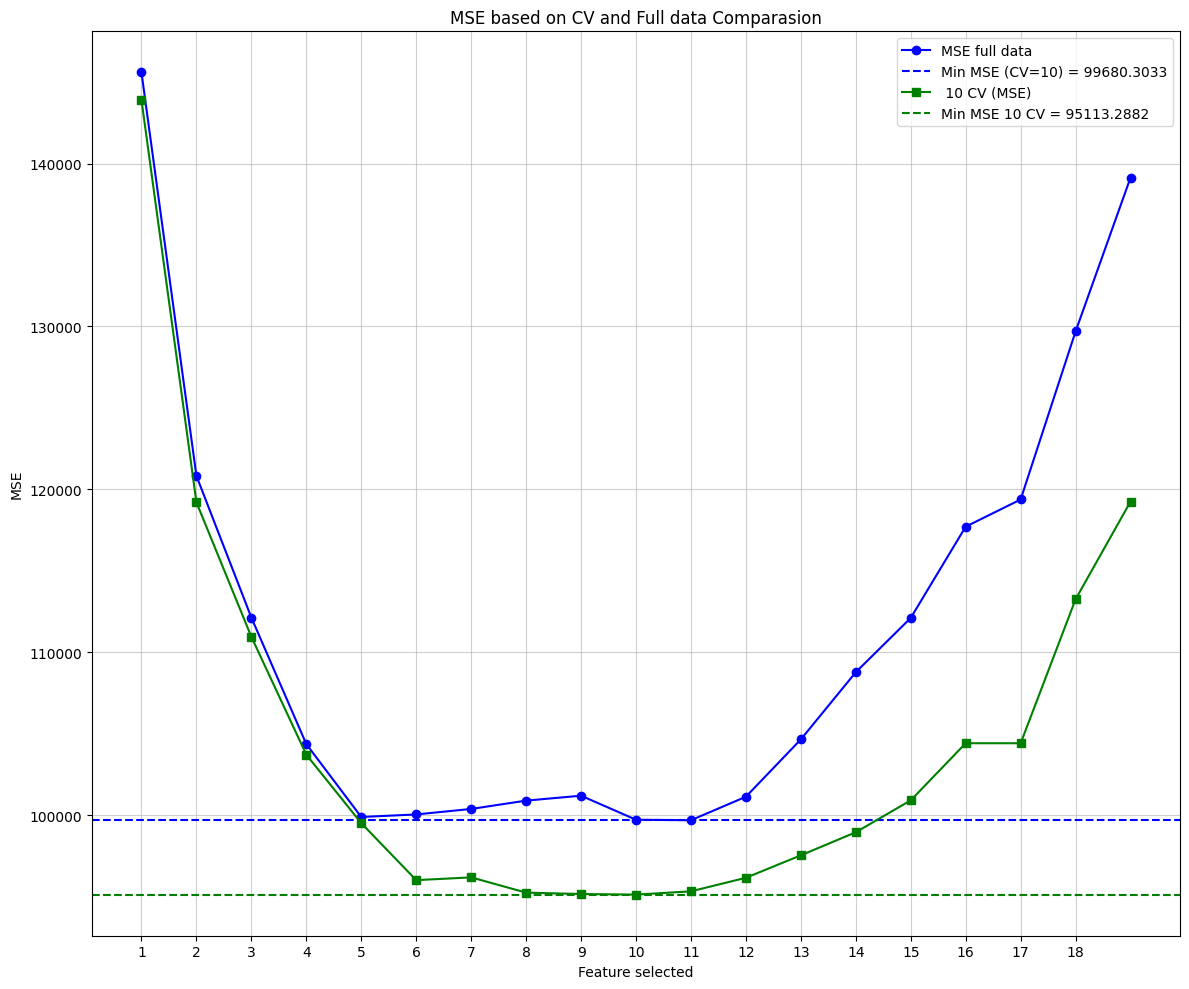

In [12]:
plt.figure(figsize=(12, 10))

plt.plot(num_features1, mse_scores1, marker='o', linestyle='-', color='b', label='MSE full data')
plt.axhline(y=minimum_mse1, color='blue', linestyle='--', label=f'Min MSE (CV=10) = {minimum_mse1:.4f}')

plt.plot(num_features2, mse_scores2, marker='s', linestyle='-', color='g', label=' 10 CV (MSE)')
plt.axhline(y=minimum_mse2, color='green', linestyle='--', label=f'Min MSE 10 CV = {minimum_mse2:.4f}')


plt.title('MSE based on CV and Full data Comparasion')
plt.xlabel('Feature selected')
plt.ylabel('MSE')
plt.xticks(ticks=range(1, len(num_features1)))
plt.grid(alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

# Using models complexity evaluators

/usr/local/lib/python3.10/dist-packages/mlxtend/feature_selection/sequential_feature_selector.py:800: RuntimeWarning: Mean of empty slice
  all_avg_scores.append(np.nanmean(cv_scores))


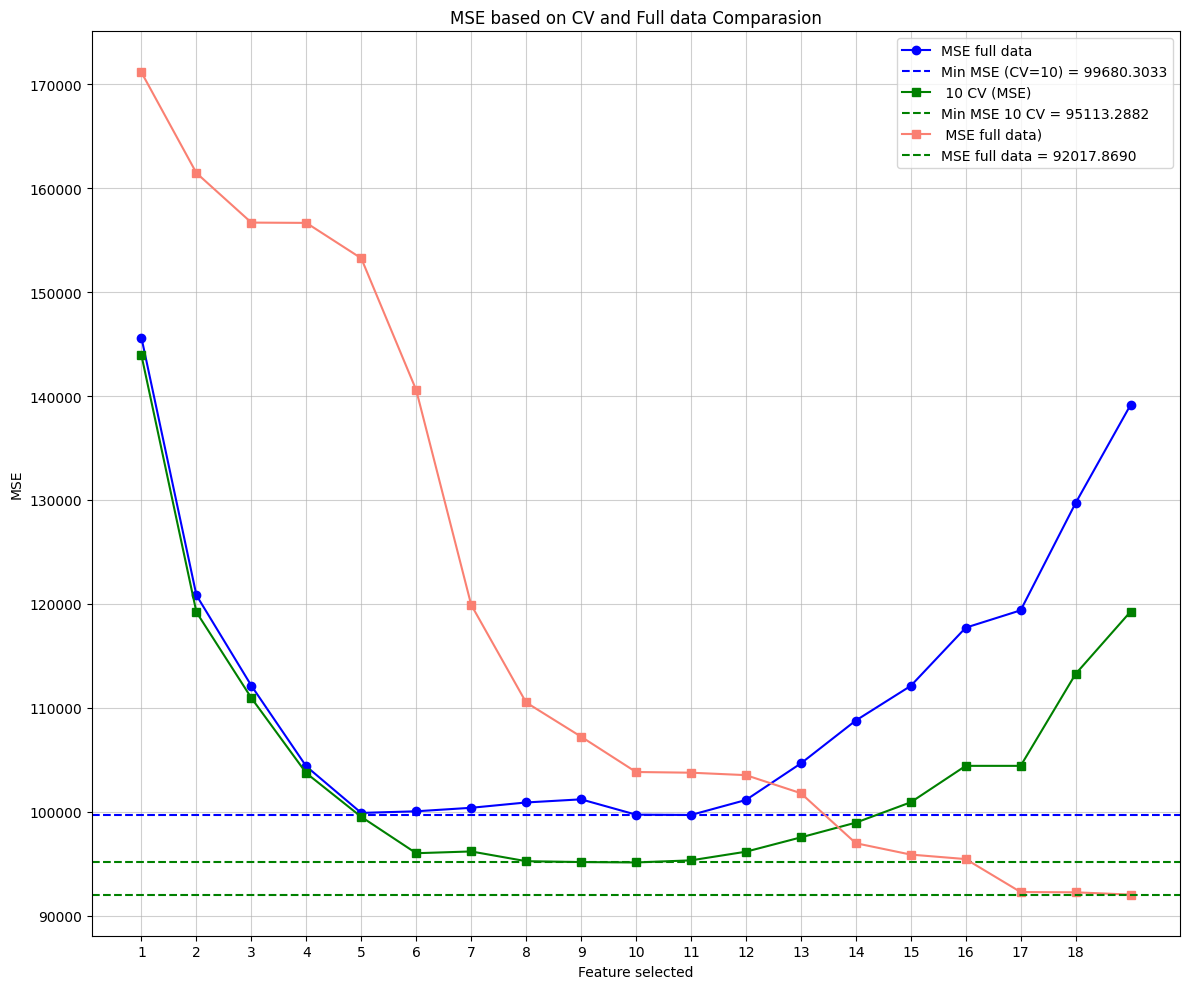

In [13]:
from sklearn.metrics import mean_squared_error

lr3 = LinearRegression()
sfs3 = SequentialFeatureSelector(estimator = lr3 , k_features='best', forward=True, scoring=score_function_wrapper('aic', lr3), n_jobs = -1)
model3 =  sfs3.fit(X_train, y_train)



results3 = sfs3.get_metric_dict()

num_features3 = []
mse_scores3 = []

for num, metrics in results3.items():
    num_features3.append(len(metrics['feature_idx']))
    selected_features = list(metrics['feature_idx'])
    X_selected = X.iloc[:, selected_features]
    y_pred = lr3.fit(X_selected, y).predict(X_selected)
    mse = mean_squared_error(y, y_pred)
    mse_scores3.append(mse)

minimum_mse3 = min(mse_scores3)



plt.figure(figsize=(12, 10))

plt.plot(num_features1, mse_scores1, marker='o', linestyle='-', color='b', label='MSE full data')
plt.axhline(y=minimum_mse1, color='blue', linestyle='--', label=f'Min MSE (CV=10) = {minimum_mse1:.4f}')

plt.plot(num_features2, mse_scores2, marker='s', linestyle='-', color='g', label=' 10 CV (MSE)')
plt.axhline(y=minimum_mse2, color='green', linestyle='--', label=f'Min MSE 10 CV = {minimum_mse2:.4f}')

plt.plot(num_features3, mse_scores3, marker='s', linestyle='-', color='salmon', label=' MSE full data)')
plt.axhline(y=minimum_mse3, color='green', linestyle='--', label=f'MSE full data = {minimum_mse3:.4f}')


plt.title('MSE based on CV and Full data Comparasion')
plt.xlabel('Feature selected')
plt.ylabel('MSE')
plt.xticks(ticks=range(1, len(num_features1)))
plt.grid(alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()
